In [1]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN, LSTM
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import numpy as np

from sklearn.metrics import mean_absolute_error        # 평균 절대값 에러(모델 평가 지수)
from sklearn.metrics import mean_squared_error         # 평균 제곱근 에러(모델 평가 지수)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
filename = '/content/drive/MyDrive/Colab Notebooks/10주차/data/stock.csv'
data = np.loadtxt(filename, delimiter=',', dtype=np.float32)
# 정규화
data = (data - np.min(data, 0)) / (np.max(data, 0) - np.min(data, 0))

print(data.shape)
print(len(data) * 0.8)    # 데이터 나누기 위해서

(9288, 5)
7430.400000000001


In [4]:
x_data = []                         # 입력데이터 리스트
y_data = []                         # 출력데이터 리스트

for i in range(0, len(data) - 5) :   # 9288 - 5
    x = data[i  :  i + 5,  :  ]        # 0 – 4 / 1 - 5 / 2 - 6 /...........
    y = data[i + 5, [-1]]            # 5      / 6      / 7     / .........
    x_data.append(x)
    y_data.append(y)

x_data = np.array(x_data)       # 리스트를 배열로 ..
y_data = np.array(y_data)

print(x_data.shape) # 샘플 수 ,타임 스탬프 수 , 입력 벡터 수
print(y_data.shape)

(9283, 5, 5)
(9283, 1)


In [5]:
print(x_data[0])                #  첫번쩨 입력 데이타
print(y_data[0])                # 첫번째 리벨

[[0.00024397 0.00024389 0.00024715 0.00034218 0.00022765]
 [0.00022654 0.00022647 0.0002295  0.00033218 0.00021014]
 [0.00022654 0.00024389 0.0002295  0.00236327 0.00022765]
 [0.00022654 0.00022647 0.00021185 0.00258739 0.00019263]
 [0.00017426 0.0001742  0.00012358 0.00099453 0.00012258]]
[0.0001401]


In [6]:
x_train = x_data[ : 7430]
y_train = y_data[ : 7430]
print(x_train.shape)
print(y_train.shape)
x_test = x_data[7430 : ]
y_test = y_data[7430 : ]
print(x_test.shape)
print(y_test.shape)

(7430, 5, 5)
(7430, 1)
(1853, 5, 5)
(1853, 1)


## RNN_1 모델

In [7]:
model = Sequential()
model.add(SimpleRNN(16, input_shape=(5, 5)))
model.add(Dense(1, activation='linear'))
model.summary()

print(f"Total params : {(16*16)+(5*16) + 16 + (16 * 1) + 1}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 16)                352       
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 369 (1.44 KB)
Trainable params: 369 (1.44 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Total params : 369


In [8]:
model_checkpoint = ModelCheckpoint(filepath =  "./model.h5", monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 3)

# 모델 학습과정 설정하기
model.compile(loss = 'mse', optimizer = optimizers.Adam(0.001), metrics=['accuracy'])

In [9]:
hist = model.fit(
                  x_train, y_train,                        # 입력 / 라벨
                  epochs = 3, batch_size = 10,            # 학습 회수 / 학습 10번 후 오차 감소
                  validation_data=(x_test, y_test),        # 검증 데이터
                  callbacks = [model_checkpoint, early_stopping] # 저장 및 모니터링
                 )

Epoch 1/3
741/743 [============================>.] - ETA: 0s - loss: 1.0397e-04 - accuracy: 0.0016
Epoch 1: val_loss improved from inf to 0.00374, saving model to ./model.h5
743/743 [==============================] - 6s 5ms/step - loss: 1.0373e-04 - accuracy: 0.0016 - val_loss: 0.0037 - val_accuracy: 5.3967e-04
Epoch 2/3
 42/743 [>.............................] - ETA: 2s - loss: 3.2086e-05 - accuracy: 0.0024    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


735/743 [============================>.] - ETA: 0s - loss: 2.7872e-05 - accuracy: 0.0016
Epoch 2: val_loss improved from 0.00374 to 0.00201, saving model to ./model.h5
743/743 [==============================] - 5s 6ms/step - loss: 2.7727e-05 - accuracy: 0.0016 - val_loss: 0.0020 - val_accuracy: 5.3967e-04
Epoch 3/3
731/743 [============================>.] - ETA: 0s - loss: 2.2951e-05 - accuracy: 0.0014
Epoch 3: val_loss improved from 0.00201 to 0.00075, saving model to ./model.h5
743/743 [==============================] - 4s 5ms/step - loss: 2.3200e-05 - accuracy: 0.0016 - val_loss: 7.5313e-04 - val_accuracy: 5.3967e-04


In [10]:
model.evaluate(x_test, y_test) # 모델 평가

# 테스트 데이터 입력하여 예측값 구하기
predict = model.predict(x_test)

# 테스트 세트에 대한 평균 절댓값 오차
mae = mean_absolute_error(y_test, predict)
mse = mean_squared_error(y_test, predict)
rmse = mse**0.5
print(mae)
print(mse)
print(rmse)

58/58 [==============================] - 1s 5ms/step
0.019418856
0.0007531346
0.02744329800652192


## RNN_2 모델

In [11]:
model = Sequential()
model.add(SimpleRNN(64, input_shape=(5, 5)))
model.add(Dense(128, activation='relu'))        # Dense 층 추가
model.add(Dense(1, activation='linear'))
model.summary()
print(f"Total params : {(64 * 64) + (5 * 64) + 64 + (64 * 128) + 128 + (128 * 1) +1}")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 64)                4480      
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 12929 (50.50 KB)
Trainable params: 12929 (50.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Total params : 12929


In [12]:
model_checkpoint = ModelCheckpoint(filepath =  "./model.h5", monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 3)

# 모델 학습과정 설정하기
model.compile(loss = 'mse', optimizer = optimizers.Adam(0.001), metrics=['accuracy'])

In [13]:
hist = model.fit(
                  x_train, y_train,                        # 입력 / 라벨
                  epochs = 3, batch_size = 10,            # 학습 회수 / 학습 10번 후 오차 감소
                  validation_data=(x_test, y_test),        # 검증 데이터
                  callbacks = [model_checkpoint, early_stopping] # 저장 및 모니터링
                 )

Epoch 1/3
734/743 [============================>.] - ETA: 0s - loss: 7.8595e-05 - accuracy: 0.0016
Epoch 1: val_loss improved from inf to 0.00180, saving model to ./model.h5
743/743 [==============================] - 8s 5ms/step - loss: 7.8139e-05 - accuracy: 0.0016 - val_loss: 0.0018 - val_accuracy: 5.3967e-04
Epoch 2/3
 40/743 [>.............................] - ETA: 2s - loss: 1.6879e-05 - accuracy: 0.0025

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


733/743 [============================>.] - ETA: 0s - loss: 3.2078e-05 - accuracy: 0.0016
Epoch 2: val_loss improved from 0.00180 to 0.00107, saving model to ./model.h5
743/743 [==============================] - 4s 5ms/step - loss: 3.1997e-05 - accuracy: 0.0016 - val_loss: 0.0011 - val_accuracy: 5.3967e-04
Epoch 3/3
738/743 [============================>.] - ETA: 0s - loss: 2.2826e-05 - accuracy: 0.0016
Epoch 3: val_loss improved from 0.00107 to 0.00067, saving model to ./model.h5
743/743 [==============================] - 5s 6ms/step - loss: 2.2714e-05 - accuracy: 0.0016 - val_loss: 6.6987e-04 - val_accuracy: 5.3967e-04


In [14]:
model.evaluate(x_test, y_test) # 모델 평가

# 테스트 데이터 입력하여 예측값 구하기
predict = model.predict(x_test)

# 테스트 세트에 대한 평균 절댓값 오차
mae = mean_absolute_error(y_test, predict)
mse = mean_squared_error(y_test, predict)
rmse = mse**0.5
print(mae)
print(mse)
print(rmse)

58/58 [==============================] - 1s 3ms/step
0.019465646
0.00066987454
0.025881934663527936


## RNN_3 모델

In [15]:
model = Sequential()
model.add(SimpleRNN(64, input_shape=(5, 5), return_sequences=True))
model.add(SimpleRNN(64))                        # RNN 2층 추가
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

print(f"Total params : {(64 * 64) + (5 * 64) + 64 + (64*64) + 64 + (64 * 128 ) + (128 * 1) + 1}")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 5, 64)             4480      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 128)               8320      
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 21185 (82.75 KB)
Trainable params: 21185 (82.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Total params : 16961


In [16]:
model_checkpoint = ModelCheckpoint(filepath =  "./model.h5", monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 3)

# 모델 학습과정 설정하기
model.compile(loss = 'mse', optimizer = optimizers.Adam(0.0001), metrics=['accuracy'])

In [17]:
hist = model.fit(
                  x_train, y_train,                        # 입력 / 라벨
                  epochs = 3, batch_size = 10,            # 학습 회수 / 학습 10번 후 오차 감소
                  validation_data=(x_test, y_test),        # 검증 데이터
                  callbacks = [model_checkpoint, early_stopping] # 저장 및 모니터링
                 )

Epoch 1/3
741/743 [============================>.] - ETA: 0s - loss: 8.6244e-05 - accuracy: 0.0016
Epoch 1: val_loss improved from inf to 0.00784, saving model to ./model.h5
743/743 [==============================] - 13s 14ms/step - loss: 8.6103e-05 - accuracy: 0.0016 - val_loss: 0.0078 - val_accuracy: 5.3967e-04
Epoch 2/3
 13/743 [..............................] - ETA: 6s - loss: 3.1946e-05 - accuracy: 0.0000e+00

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


742/743 [============================>.] - ETA: 0s - loss: 3.4927e-05 - accuracy: 0.0016
Epoch 2: val_loss improved from 0.00784 to 0.00660, saving model to ./model.h5
743/743 [==============================] - 7s 9ms/step - loss: 3.4889e-05 - accuracy: 0.0016 - val_loss: 0.0066 - val_accuracy: 5.3967e-04
Epoch 3/3
742/743 [============================>.] - ETA: 0s - loss: 3.3075e-05 - accuracy: 0.0016
Epoch 3: val_loss improved from 0.00660 to 0.00379, saving model to ./model.h5
743/743 [==============================] - 9s 12ms/step - loss: 3.3112e-05 - accuracy: 0.0016 - val_loss: 0.0038 - val_accuracy: 5.3967e-04


In [18]:
model.evaluate(x_test, y_test) # 모델 평가

# 테스트 데이터 입력하여 예측값 구하기
predict = model.predict(x_test)

# 테스트 세트에 대한 평균 절댓값 오차
mae = mean_absolute_error(y_test, predict)
mse = mean_squared_error(y_test, predict)
rmse = mse**0.5
print(mae)
print(mse)
print(rmse)

58/58 [==============================] - 0s 3ms/step
0.04134475
0.0037946173
0.061600464709483806


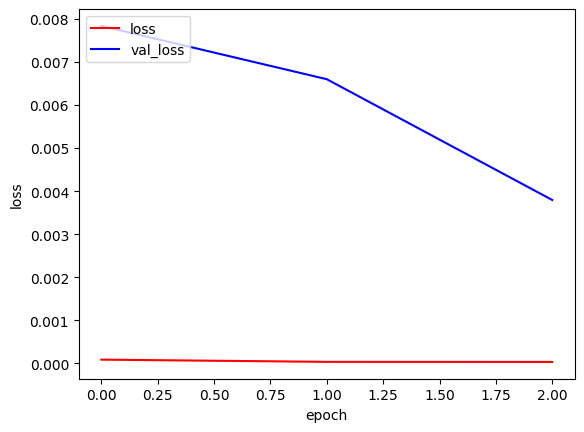

In [19]:
# 그래프 출력
import matplotlib.pyplot as plt
# 과정 살펴보기
plt.plot(hist.history['loss'], 'r', label = 'loss')
plt.plot(hist.history['val_loss'], 'b', label = 'val_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

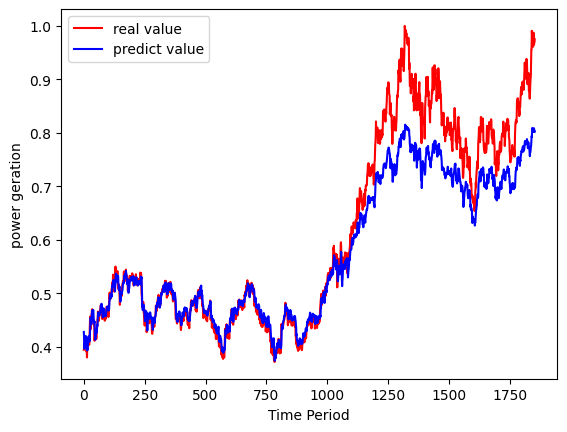

In [20]:
plt.plot(y_test[ : ], 'r', label = "real value")
plt.plot(predict[ : ], 'b', label = "predict value")
plt.xlabel("Time Period")
plt.ylabel('power geration')
plt.legend(loc='upper left')
plt.show()